In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import os
import shutil
import random

In [23]:
def rotate_yolo_labels(label_dir, output_dir, angle):
    """
    批量旋转YOLO格式标签文件（.txt）
    :param label_dir: 输入标签文件夹路径
    :param output_dir: 输出标签文件夹路径
    :param angle: 旋转角度（只能是90, 180, 270）
    """
    angle = angle % 360
    assert angle in [90, 180, 270], "只支持旋转角度为 90, 180, 270 度"

    os.makedirs(output_dir, exist_ok=True)

    for label_file in Path(label_dir).glob("*.txt"):
        with open(label_file, "r") as f:
            lines = f.readlines()

        rotated_lines = []
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls, x, y, w, h = parts
            x, y, w, h = map(float, [x, y, w, h])

            # 坐标变换
            if angle == 90:
                x_new, y_new = y, 1 - x
                w_new, h_new = h, w
            elif angle == 180:
                x_new, y_new = 1 - x, 1 - y
                w_new, h_new = w, h
            elif angle == 270:
                x_new, y_new = 1 - y, x
                w_new, h_new = h, w

            rotated_line = f"{cls} {x_new:.6f} {y_new:.6f} {w_new:.6f} {h_new:.6f}"
            rotated_lines.append(rotated_line)

        out_path = Path(output_dir) / label_file.name
        with open(out_path, "w") as f:
            f.write("\n".join(rotated_lines))

        print(f"✅ Rotated label: {label_file.name}")


In [47]:
def rotate_and_scale_no_padding(image, angle, scale=2.0):
    """
    旋转图像 + 去除黑边 + 放大处理。
    """
    h, w = image.shape[:2]
    center = (w / 2, h / 2)

    # 计算旋转矩阵
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # 计算旋转后图像的新边界尺寸（自动扩展）
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    new_w = int(h * sin + w * cos)
    new_h = int(h * cos + w * sin)

    # 调整旋转矩阵偏移量，使图像居中
    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]

    # 旋转 + 扩大 canvas
    rotated = cv2.warpAffine(image, M, (new_w, new_h), flags=cv2.INTER_LINEAR)

    # 自动裁剪掉四边黑边（基于非零区域）
    gray = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x, y, w_box, h_box = cv2.boundingRect(contours[0])
        cropped = rotated[y:y+h_box, x:x+w_box]
    else:
        cropped = rotated  # 万一找不到轮廓就不裁剪

    # 最后放大
    if scale != 1.0:
        new_w = int(cropped.shape[1] * scale)
        new_h = int(cropped.shape[0] * scale)
        cropped = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

    return cropped

In [48]:
def process_folder(input_dir, output_dir, rotate_deg=90, scale_factor=1.3):
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    for img_file in input_dir.iterdir():
        if img_file.suffix.lower() not in [".jpg", ".jpeg", ".png"]:
            continue
        img = cv2.imread(str(img_file))
        if img is None:
            print(f"⚠️ Failed to read {img_file}")
            continue

        processed = rotate_and_scale_no_padding(img, rotate_deg, scale_factor)
        out_path = output_dir / img_file.name
        cv2.imwrite(str(out_path), processed)
        print(f"✅ Processed: {img_file.name}")

In [14]:
output_dir = "Train_data/scaled"
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [59]:
process_folder(
    input_dir="Train_data/images",  # 输入文件夹路径
    output_dir="Train_data/scaled",  # 输出文件夹路径
    rotate_deg=270,  # 顺时针旋转角度
    scale_factor=1.3,
)

✅ Processed: 0029aa17-000397.jpg
✅ Processed: 00e4351f-000274.jpg
✅ Processed: 024766d1-000332.jpg
✅ Processed: 027153e1-000017.jpg
✅ Processed: 03f14609-000376.jpg
✅ Processed: 046fae5c-000345.jpg
✅ Processed: 04dde30d-000137.jpg
✅ Processed: 05664287-000364.jpg
✅ Processed: 06aacd77-000262.jpg
✅ Processed: 07362b9d-000370.jpg
✅ Processed: 09466079-000277.jpg
✅ Processed: 0948c26d-000237.jpg
✅ Processed: 096c0e21-000158.jpg
✅ Processed: 09e82928-000350.jpg
✅ Processed: 0a28d5d7-000038.jpg
✅ Processed: 0a455ca4-000259.jpg
✅ Processed: 0a634633-000070.jpg
✅ Processed: 0ae9ade1-000337.jpg
✅ Processed: 0b3dd5b3-000331.jpg
✅ Processed: 0bc3a7d2-000223.jpg
✅ Processed: 0cf8c8be-000250.jpg
✅ Processed: 0cff5911-000312.jpg
✅ Processed: 0d55dd04-000210.jpg
✅ Processed: 0dab99d7-000258.jpg
✅ Processed: 0efb38a1-000010.jpg
✅ Processed: 0f4fcf1d-000390.jpg
✅ Processed: 110f8dda-000202.jpg
✅ Processed: 118dd9e9-000216.jpg
✅ Processed: 11ce257c-000276.jpg
✅ Processed: 11e78274-000362.jpg
✅ Processe

In [54]:
output_dir = "Train_data/scaled_label"
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [55]:
rotate_yolo_labels(
    label_dir="Train_data/labels",
    output_dir="Train_data/scaled_label",
    angle=270,
)

✅ Rotated label: 0029aa17-000397.txt
✅ Rotated label: 00e4351f-000274.txt
✅ Rotated label: 024766d1-000332.txt
✅ Rotated label: 027153e1-000017.txt
✅ Rotated label: 03f14609-000376.txt
✅ Rotated label: 046fae5c-000345.txt
✅ Rotated label: 04dde30d-000137.txt
✅ Rotated label: 05664287-000364.txt
✅ Rotated label: 06aacd77-000262.txt
✅ Rotated label: 07362b9d-000370.txt
✅ Rotated label: 09466079-000277.txt
✅ Rotated label: 0948c26d-000237.txt
✅ Rotated label: 096c0e21-000158.txt
✅ Rotated label: 09e82928-000350.txt
✅ Rotated label: 0a28d5d7-000038.txt
✅ Rotated label: 0a455ca4-000259.txt
✅ Rotated label: 0a634633-000070.txt
✅ Rotated label: 0ae9ade1-000337.txt
✅ Rotated label: 0b3dd5b3-000331.txt
✅ Rotated label: 0bc3a7d2-000223.txt
✅ Rotated label: 0cf8c8be-000250.txt
✅ Rotated label: 0cff5911-000312.txt
✅ Rotated label: 0d55dd04-000210.txt
✅ Rotated label: 0dab99d7-000258.txt
✅ Rotated label: 0efb38a1-000010.txt
✅ Rotated label: 0f4fcf1d-000390.txt
✅ Rotated label: 110f8dda-000202.txt
✅

In [56]:
def show_yolo_labels_from_txt(
    image_path, label_path, box_color=(0, 255, 0), box_thickness=2, figsize=(10, 10)
):
    """
    从 YOLO 格式的 .txt 文件中读取标签并绘制在图像上。

    :param image_path: 图像路径（jpg/png）
    :param label_path: 标签路径（txt）
    :param box_color: 边框颜色（BGR）
    :param box_thickness: 边框线宽
    :param figsize: matplotlib 图像显示尺寸
    """
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"无法读取图像文件：{image_path}")
    h, w = img.shape[:2]

    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            continue  # 跳过格式异常的行
        cls, x, y, bw, bh = map(float, parts)
        cx = x * w
        cy = y * h
        box_w = bw * w
        box_h = bh * h

        x1 = int(cx - box_w / 2)
        y1 = int(cy - box_h / 2)
        x2 = int(cx + box_w / 2)
        y2 = int(cy + box_h / 2)

        cv2.rectangle(img, (x1, y1), (x2, y2), box_color, box_thickness)

    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("YOLO Labels on Image")
    plt.axis("off")
    plt.show()


<positron-console-cell-57>:2: SyntaxWarning: invalid escape sequence '\i'


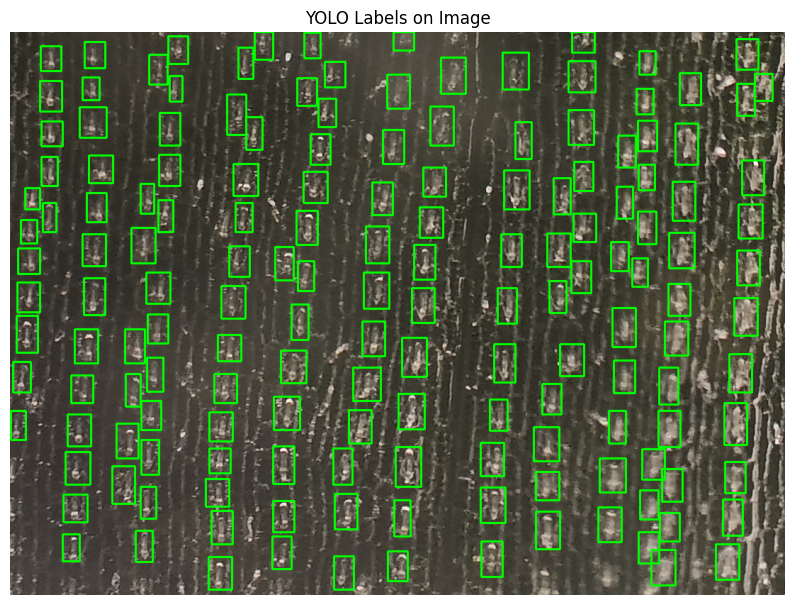

In [57]:
show_yolo_labels_from_txt(
    image_path="Train_data\images/0a28d5d7-000038.jpg", label_path="Train_data/labels/0a28d5d7-000038.txt"
)

<positron-console-cell-61>:2: SyntaxWarning: invalid escape sequence '\s'


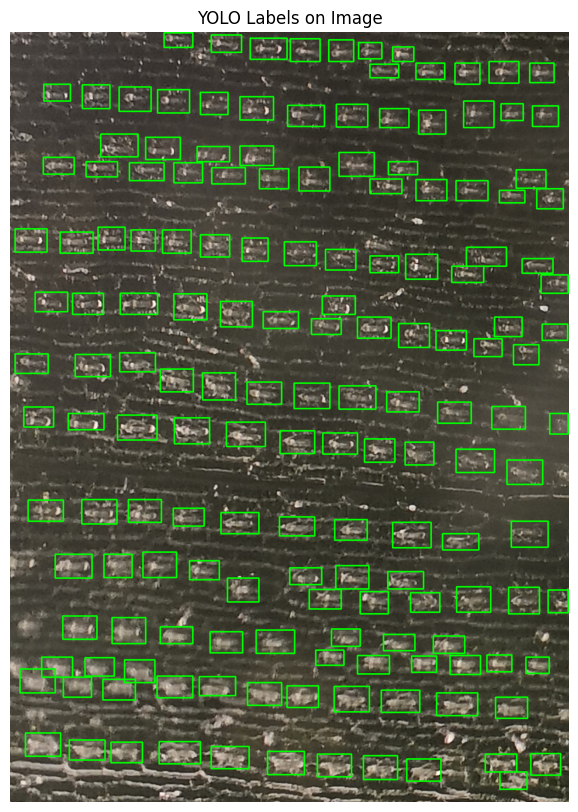

In [61]:
show_yolo_labels_from_txt(
    image_path="Train_data\scaled/0a28d5d7-000038.jpg", label_path="Train_data/scaled_label/0a28d5d7-000038.txt"
)

In [ ]:
def sliding_window_with_yolo_labels(image_path, label_path, output_dir, crop_size=640, overlap=0.2):
    """
    滑窗裁剪图像并同步处理YOLO标签，支持自定义重叠率。
    
    :param image_path: 图像路径
    :param label_path: YOLO格式标签路径
    :param output_dir: 输出目录
    :param crop_size: 每个裁剪图像的尺寸（默认640x640）
    :param overlap: 重叠比例 (0~1)，0表示不重叠，0.5表示滑窗每次移动一半
    """

    filename = os.path.basename(image_path)  
    name_wo_ext = os.path.splitext(filename)[0]

    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"图像无法读取: {image_path}")
    h, w = image.shape[:2]

    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # 读取标签
    abs_boxes = []
    with open(label_path, "r") as f:
        for line in f:
            cls, x, y, bw, bh = map(float, line.strip().split())
            cx = x * w
            cy = y * h
            bw *= w
            bh *= h
            abs_boxes.append((cls, cx, cy, bw, bh))

    stride = int(crop_size * (1 - overlap))
    count = 0
    for y0 in range(0, h - crop_size + 1, stride):
        for x0 in range(0, w - crop_size + 1, stride):
            crop = image[y0:y0+crop_size, x0:x0+crop_size]
            crop_boxes = []

            for cls, cx, cy, bw, bh in abs_boxes:
                x1 = cx - bw / 2
                y1 = cy - bh / 2
                x2 = cx + bw / 2
                y2 = cy + bh / 2

                ix1 = max(x1, x0)
                iy1 = max(y1, y0)
                ix2 = min(x2, x0 + crop_size)
                iy2 = min(y2, y0 + crop_size)

                if ix2 > ix1 and iy2 > iy1:
                    new_cx = (ix1 + ix2) / 2 - x0
                    new_cy = (iy1 + iy2) / 2 - y0
                    new_bw = ix2 - ix1
                    new_bh = iy2 - iy1

                    crop_boxes.append(
                        f"{int(cls)} {new_cx / crop_size:.6f} {new_cy / crop_size:.6f} {new_bw / crop_size:.6f} {new_bh / crop_size:.6f}"
                    )

            if crop_boxes:
                crop_img_name = f"{name_wo_ext}_crop_{count:04d}.jpg"
                crop_txt_name = f"{name_wo_ext}_crop_{count:04d}.txt"
                cv2.imwrite(str(output_dir / crop_img_name), crop)
                with open(output_dir / crop_txt_name, "w") as f:
                    f.write("\n".join(crop_boxes))
                count += 1

    return count

In [89]:
output_dir = "Train_data/temp"
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [88]:
output_dir = "Train_data/data_for_train_img"
Path(output_dir).mkdir(parents=True, exist_ok=True)

output_dir = "Train_data/data_for_train_label"
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [90]:
def batch_cut_folder(image_dir, label_dir, output_dir, crop_size=640, overlap=0.2):
    image_dir = Path(image_dir)
    label_dir = Path(label_dir)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    total = 0
    for img_file in image_dir.glob("*.*"):
        if img_file.suffix.lower() not in [".jpg", ".png", ".jpeg"]:
            continue
        label_file = label_dir / (img_file.stem + ".txt")
        if not label_file.exists():
            print(f"⚠️ 未找到对应标签: {label_file}")
            continue
        n = sliding_window_with_yolo_labels(img_file, label_file, output_dir, crop_size, overlap)
        print(f"✅ {img_file.name} -> 生成 {n} 个 patch")
        total += n

    print(f"\n🎉 总计生成 {total} 个切割图像及标签")

In [92]:
batch_cut_folder(
    image_dir="Train_data/scaled",
    label_dir="Train_data/scaled_label",
    output_dir="Train_data/temp",
    crop_size=640,
    overlap=0.5
)

✅ 0029aa17-000397.jpg -> 生成 6 个 patch
✅ 00e4351f-000274.jpg -> 生成 6 个 patch
✅ 024766d1-000332.jpg -> 生成 6 个 patch
✅ 027153e1-000017.jpg -> 生成 6 个 patch
✅ 03f14609-000376.jpg -> 生成 6 个 patch
✅ 046fae5c-000345.jpg -> 生成 6 个 patch
✅ 04dde30d-000137.jpg -> 生成 6 个 patch
✅ 05664287-000364.jpg -> 生成 6 个 patch
✅ 06aacd77-000262.jpg -> 生成 6 个 patch
✅ 07362b9d-000370.jpg -> 生成 6 个 patch
✅ 09466079-000277.jpg -> 生成 6 个 patch
✅ 0948c26d-000237.jpg -> 生成 6 个 patch
✅ 096c0e21-000158.jpg -> 生成 6 个 patch
✅ 09e82928-000350.jpg -> 生成 6 个 patch
✅ 0a28d5d7-000038.jpg -> 生成 6 个 patch
✅ 0a455ca4-000259.jpg -> 生成 6 个 patch
✅ 0a634633-000070.jpg -> 生成 6 个 patch
✅ 0ae9ade1-000337.jpg -> 生成 6 个 patch
✅ 0b3dd5b3-000331.jpg -> 生成 6 个 patch
✅ 0bc3a7d2-000223.jpg -> 生成 6 个 patch
✅ 0cf8c8be-000250.jpg -> 生成 6 个 patch
✅ 0cff5911-000312.jpg -> 生成 6 个 patch
✅ 0d55dd04-000210.jpg -> 生成 6 个 patch
✅ 0dab99d7-000258.jpg -> 生成 6 个 patch
✅ 0efb38a1-000010.jpg -> 生成 6 个 patch
✅ 0f4fcf1d-000390.jpg -> 生成 6 个 patch
✅ 110f8dda-0

In [93]:
batch_cut_folder(
    image_dir="HaN/images",
    label_dir="HaN/labels",
    output_dir="HaN/temp",
    crop_size=640,
    overlap=0.5
)

✅ 01fe4b57-34_2.jpg -> 生成 8 个 patch
✅ 078c6119-31_3.jpg -> 生成 8 个 patch
✅ 11469343-38_2.jpg -> 生成 8 个 patch
✅ 19b873af-31_2.jpg -> 生成 8 个 patch
✅ 21c78979-31.jpg -> 生成 8 个 patch
✅ 28cfaa07-66.jpg -> 生成 8 个 patch
✅ 2c73d0ef-37_2.jpg -> 生成 8 个 patch
✅ 30f5c2ed-32.jpg -> 生成 8 个 patch
✅ 389866ae-41_2.jpg -> 生成 8 个 patch
✅ 38a45c7a-41.jpg -> 生成 8 个 patch
✅ 3cbe2935-39_4.jpg -> 生成 8 个 patch
✅ 3e6c4c6d-35_3.jpg -> 生成 8 个 patch
✅ 41e49b95-40.jpg -> 生成 8 个 patch
✅ 53c63d08-39_5.jpg -> 生成 8 个 patch
✅ 57043abe-36_3.jpg -> 生成 8 个 patch
✅ 6985f4cf-38_3.jpg -> 生成 8 个 patch
✅ 6feda989-36.jpg -> 生成 8 个 patch
✅ 726a94e7-39_3.jpg -> 生成 8 个 patch
✅ 7a003a36-36_2.jpg -> 生成 8 个 patch
✅ 81809044-80_3.jpg -> 生成 8 个 patch
✅ 860dcd82-38.jpg -> 生成 8 个 patch
✅ 87f0c733-32_3.jpg -> 生成 8 个 patch
✅ 8a6d4f39-71_3.jpg -> 生成 8 个 patch
✅ 99d5456b-37.jpg -> 生成 8 个 patch
✅ 9d5700d4-37_3.jpg -> 生成 8 个 patch
✅ a1071f11-33.jpg -> 生成 8 个 patch
✅ a1426383-39_2.jpg -> 生成 8 个 patch
✅ a3f5854e-34.jpg -> 生成 8 个 patch
✅ aa5087f3-3

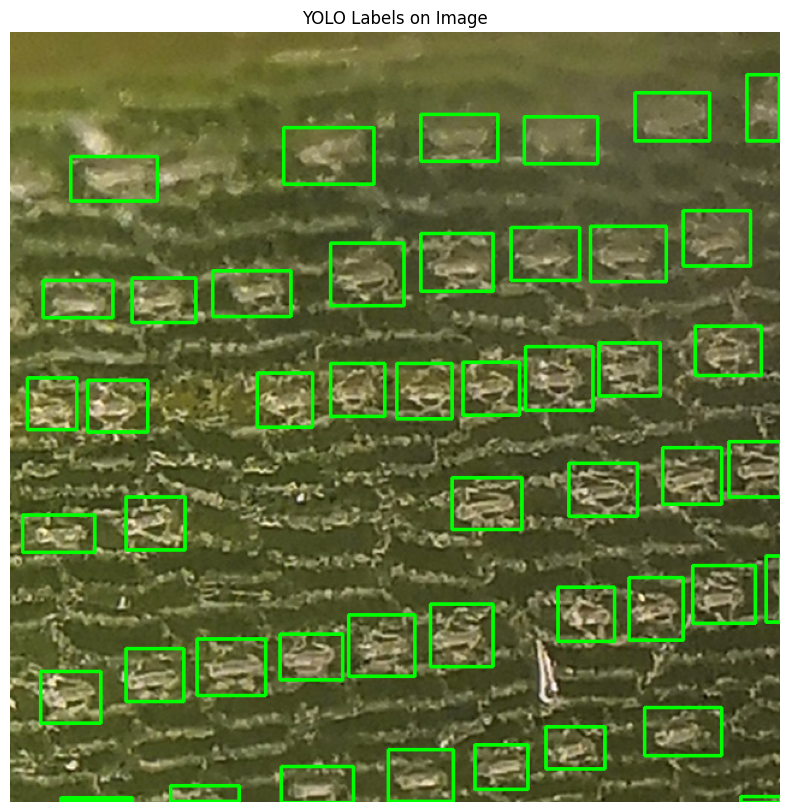

In [95]:
show_yolo_labels_from_txt(
    image_path="Yolo_train/Img/4b2b360e-000211_crop_0000.jpg", label_path="Yolo_train/Label/4b2b360e-000211_crop_0000.txt"
)

In [ ]:

def split_yolo_dataset(base_dir, train_ratio=0.8, seed=42):
    base_dir = Path(base_dir)
    images_dir = base_dir / "images"
    labels_dir = base_dir / "labels"
    train_dir = base_dir / "train"
    val_dir = base_dir / "val"

    # 创建目标目录
    for subset in [train_dir, val_dir]:
        (subset / "images").mkdir(parents=True, exist_ok=True)
        (subset / "labels").mkdir(parents=True, exist_ok=True)

    # 获取所有图像文件名（只保留存在标签的）
    all_images = sorted([p for p in images_dir.glob("*.*") if (labels_dir / (p.stem + ".txt")).exists()])
    random.seed(seed)
    random.shuffle(all_images)

    split_idx = int(len(all_images) * train_ratio)
    train_images = all_images[:split_idx]
    val_images = all_images[split_idx:]

    def copy_subset(images, subset_dir):
        for img_path in images:
            label_path = labels_dir / (img_path.stem + ".txt")
            shutil.copy(img_path, subset_dir / "images" / img_path.name)
            shutil.copy(label_path, subset_dir / "labels" / label_path.name)

    copy_subset(train_images, train_dir)
    copy_subset(val_images, val_dir)

    print(f"✅ 数据集划分完成：")
    print(f"训练集：{len(train_images)} 张图像")
    print(f"验证集：{len(val_images)} 张图像")
    print(f"输出目录：{train_dir} 和 {val_dir}")



In [97]:
split_yolo_dataset("Yolo_train", train_ratio=0.8)

✅ 数据集划分完成：
训练集：2163 张图像
验证集：541 张图像
输出目录：Yolo_train\train 和 Yolo_train\val
